In [1]:
import numpy as np
import argparse
from PIL import Image
import os
import scipy.io as sio
import matplotlib.image as iming
import matplotlib.pyplot as plt
from skimage import io,data,color

SPLIT_RATIO = 0.2 #train-test split ratio
h_appearance = 50
h_landmark = 10


In [2]:
parser = argparse.ArgumentParser(description='stat231_project1')
parser.add_argument('--image_dir', type=str, default='./data/images/')
parser.add_argument('--landmark_dir', type=str, default='./data/landmarks/')
parser.add_argument('--path', type=str, default='./results/model/')
parser.add_argument('--log', type=str, default='./results/log_pca/')

_StoreAction(option_strings=['--log'], dest='log', nargs=None, const=None, default='./results/log_pca/', type=<class 'str'>, choices=None, help=None, metavar=None)

In [3]:
# Read Dataset
class data_reader(object):
    def __init__(self, root_dir, file_str_len, origin_name, file_format):
        self.root_dir = root_dir
        self.file_str_len = file_str_len
        self.origin_name = origin_name
        self.file_format = file_format

    def read(self, split, read_type):
        files_len = len([name for name in os.listdir(self.root_dir) 
                        if os.path.isfile(os.path.join(self.root_dir, name))])
        counter = 0
        idx = counter
        dataset = []
        train_dataset = []
        test_dataset = []
        while counter < files_len:
            name = self.origin_name + str(idx)
            if len(name) > self.file_str_len:
                name = name[len(name)-self.file_str_len:]
            try:
                if read_type == 'image':
                    data = io.imread(self.root_dir + name + self.file_format)
                elif read_type == 'landmark':
                    mat_data = sio.loadmat(self.root_dir + name + self.file_format)

                    data = mat_data['lms']
                dataset.append(data)
                counter = counter + 1
            except FileNotFoundError:
                pass
            idx = idx + 1
        n = len(dataset)
        train_dataset = np.array(dataset[:int((1-split)*n)])
        test_dataset = np.array(dataset[int((1-split)*n):])
        return train_dataset, test_dataset

In [4]:
class pca(object):
    def __init__(self, data):
        data = np.array(data)
        data = data.reshape([data.shape[0], -1]) #shape: n X d
        mean = np.mean(data, axis = 0) #shape:d
        self.data = data
        self.mean = mean
        self.n, self.d = data.shape
        self.get_eigen_vector()
    
    def get_eigen_vector(self):
        """
        Compute eigen-vectors and eigen values of data
        """
        data, mean = self.data, self.mean
        data -= mean[np.newaxis, :]
        # compute covariance matrix
        # the eigen values of XX.T is same as X.TX
        if self.d > self.n: # save computing time
            covariance = np.dot(data,data.T) #shape: n X n
            eigen_values, eigen_vectors = np.linalg.eig(covariance)
            eigen_vectors = np.dot(data.T, eigen_vectors) #shape:d X n
            
        else:
            covariance = np.dot(data.T, data)# shape: d X d
            eigen_values, eigen_vectors = np.linalg.eig(covariance)

        eigen_vectors = eigen_vectors / np.sqrt(np.sum(eigen_vectors * eigen_vectors, axis=0, keepdims=True))
        sorted_idx = eigen_values.argsort()[::-1]
        eigen_values = eigen_values[sorted_idx]
        eigen_vectors = eigen_vectors[:, sorted_idx]
        
        self.eigen_vectors = eigen_vectors
        self.eigen_values = eigen_values

    def reconstruct(self, images, K=50):
        """
        Reconstruct images with h eigen-vectors and compute reconstruction errors (squared 
        intensity difference between the reconstructed images and their original ones per pixel)
        @param images: original images to be reconstructed
        @param K: number of eigen-vectors used to reconstruct
        @return reconstructions and reconstruction errors
        """
        mean = self.mean
        eigen_vectors = self.eigen_vectors[:, :K]
        weight = np.dot(images-mean, eigen_vectors) # n X k
        reconstructions = np.dot(weight, eigen_vectors.T) + mean # n X d
        error = images - reconstructions
        error = np.mean(error * error)
        
        return reconstructions, error
    
    def sampling(self, n_sample=1, K=50, coef=50.):
        """
        Synthesize random data 
        @param K: number of eigen-vectors
        @param coef: 
        @param n_sample: number of data to be synthesized
        @return synthesized data
        """
        mean = self.mean
        eigen_values = self.eigen_values 
        eigen_vectors = self.eigen_vectors[:, :K]
        weight = np.zeros((n_sample, K))
        for i in range(K):
            weight[:,i] = np.random.normal(0., np.sqrt(eigen_values[i])/coef, n_sample)
        reconstructions = np.dot(weight, eigen_vectors.T) + mean
        
        return reconstructions

### Dataset Generation
Divide the 1000 faces into two parts: the first 800 faces form a training set, and the remaining 200 faces form the test set

In [5]:
args = parser.parse_args('')
if not os.path.exists(args.path):
    os.makedirs(args.path)
if not os.path.exists(args.log):
    os.makedirs(args.log)

appearance_reader = data_reader(args.image_dir, 6, '000000', '.jpg')
appearance_train, appearance_test = appearance_reader.read(split=SPLIT_RATIO, \
                                                                read_type='image')
landmark_reader = data_reader(args.landmark_dir, 6, '000000', '.mat')
landmark_train, landmark_test = landmark_reader.read(split=SPLIT_RATIO, \
                                                                read_type='landmark')

n_train = len(appearance_train)
n_test = len(appearance_test)
n = n_train + n_test

## Active Appearance Model (AAM)

In [6]:
#get HSV, V cahnnel dataset for appearance
appearance_hsv_train = []
appearance_hsv_test = []
for i in range(n_train):
    image_hsv = color.rgb2hsv(appearance_train[i])
    appearance_hsv_train.append(image_hsv)

for i in range(n_test):
    image_hsv = color.rgb2hsv(appearance_test[i])
    appearance_hsv_test.append(image_hsv)

appearance_v_train = np.array(appearance_hsv_train)[:,:,:,2]
appearance_v_test = np.array(appearance_hsv_test)[:,:,:,2]

/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


In [7]:
pca_appearance = pca(appearance_v_train)

### Display first 10 eigen-vectors for appearance

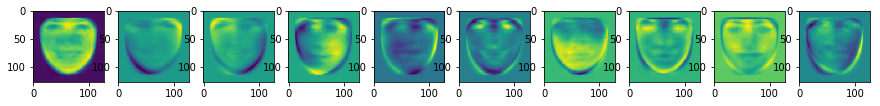

In [8]:
eigen_faces = pca_appearance.eigen_vectors[:, :10].T.reshape([-1, 128, 128])

plt.figure(figsize = (15,1.5))
for i in range(10):
    pc = eigen_faces[i,:,:]
    plt.subplot(1,10,i+1)
    plt.imshow(pc)

### Display reconstruction error with number of eigen-vectors

[0.02064094691717968, 0.01140949665771958, 0.009101139851460502, 0.007960609862707463, 0.007078087515536351, 0.0065154221836941665, 0.0060390348477091646, 0.005696585658330159, 0.0053855371574619455, 0.005133410016692386]


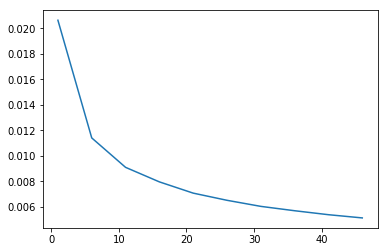

In [9]:
K_list = np.arange(1, h_appearance, 5)
reconstruction_errors = []
for K in K_list:
    reconstruction, error = pca_appearance.reconstruct(appearance_v_test.reshape([-1,128*128]), K)
    reconstruction_errors.append(error)

plt.plot(K_list, reconstruction_errors)

print(reconstruction_errors)

### Choose 50 eigen-vectors to reconstruct appearance
### Display 10 reconstructed faces and the corresponding original faces.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

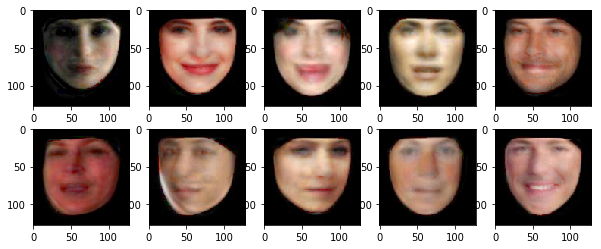

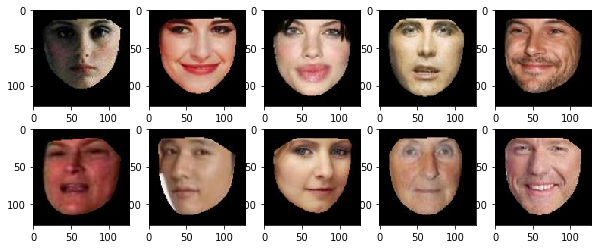

In [10]:
appearance_reconstruction, _ = pca_appearance.reconstruct(appearance_v_test.reshape([-1,128*128]))

plt.figure(figsize = (10,4))
for i in range(10): #reconstruct 10 test images
    image_hsv = appearance_hsv_test[i]
    image_hsv[:,:,2] = appearance_reconstruction[i,:].reshape([-1,128,128])
    image_rgb = color.hsv2rgb(image_hsv)
    plt.subplot(2,5,i+1)
    plt.imshow(image_rgb)
plt.figure(figsize = (10,4))

for i in range(10): # 10 original test images
    image_rgb = appearance_test[i]
    plt.subplot(2,5,i+1)
    plt.imshow(image_rgb)

## Active Shape Model (ASM)

In [11]:
pca_landmark = pca(landmark_train)

### Display first 10 eigen-vectors

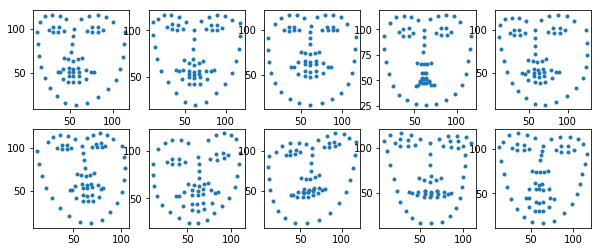

In [12]:
eigen_landmarks = pca_landmark.eigen_vectors[:, :10].T.reshape([-1, 68, 2])

plt.figure(figsize = (10,4))
for i in range(10):
    pc = eigen_landmarks[i,:,:]* 50 + pca_landmark.mean.reshape(68,2)
    pt_x = pc[:,0]
    pt_y = -pc[:,1] + 128
    plt.subplot(2,5,i+1)
    plt.plot(pt_x,pt_y,marker = '.',ls = 'None')

### Display reconstruction error with number of eigen-vectors

[6.3338125161185825, 3.9908275662957893, 2.241468548749607, 1.5735455011508643, 1.159151005791626, 0.7034359029066611, 0.5118736880524735, 0.38056049337190645, 0.28906889332549845]


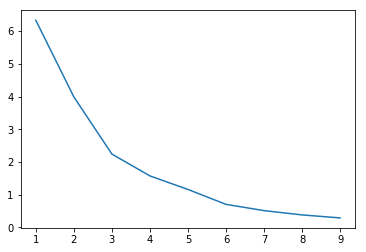

In [13]:
K_list = np.arange(1, 10, 1)
reconstruction_errors = []
for K in K_list:
    reconstruction, error = pca_landmark.reconstruct(landmark_test.reshape([-1,68*2]), K)
    reconstruction_errors.append(error)

plt.plot(K_list, reconstruction_errors)

print(reconstruction_errors)

### Choose 10 eigen-vectors to reconstruct landmarks
### Display 10 reconstructed landmarks and the corresponding original landmarks.

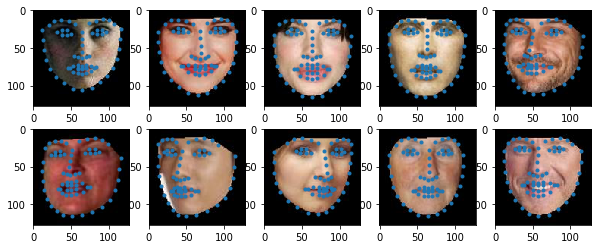

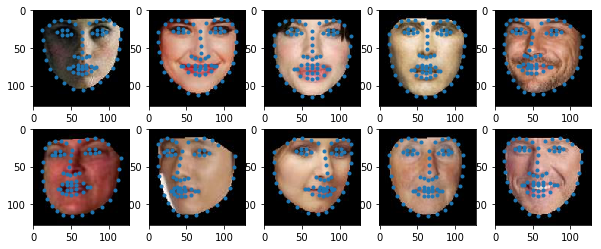

In [14]:
landmark_reconstruction, _ = pca_landmark.reconstruct(landmark_test.reshape([-1,68*2]))
plt.figure(figsize = (10,4))
for i in range(10): #reconstruct landmark in 10 test images
    img_rgb = appearance_test[i]
    plt.subplot(2,5,i+1)
    pt_x = landmark_reconstruction[i,:].reshape([68,2])[:,0]
    pt_y = landmark_reconstruction[i,:].reshape([68,2])[:,1]
    plt.imshow(img_rgb)
    plt.plot(pt_x,pt_y,marker = '.',ls = 'None')

plt.figure(figsize = (10,4))
for i in range(10): # original landmark in 10 test images
    img_rgb = appearance_test[i]
    plt.subplot(2,5,i+1)
    pt_x = landmark_test[i,:,0]
    pt_y = landmark_test[i,:,1]
    plt.imshow(img_rgb)
    plt.plot(pt_x,pt_y,marker = '.',ls = 'None')

## Combine appearance and shape

Training images, warping landmarks to mean position

In [15]:
import mywarper
warp_appearance_train = []
for i in range(n_train):
    warp_appearance_train.append(mywarper.warp(appearance_train[i,:,:], landmark_train[i,:,:], 
                                               pca_landmark.mean.reshape(68,2)))
warp_appearance_train = np.array(warp_appearance_train) #shape: n_train X 128 X 128 X 3

warp_appearance_test = []
for i in range(n_test):
    warp_appearance_test.append(mywarper.warp(appearance_test[i,:,:], landmark_test[i,:,:], 
                                               pca_landmark.mean.reshape(68,2)))
warp_appearance_test = np.array(warp_appearance_test) #shape: n_test X 128 X 128 X 3

### Display wrapped faces

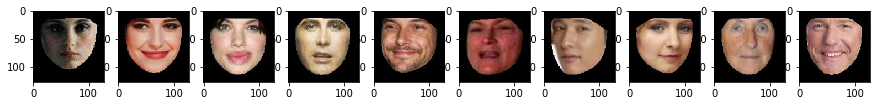

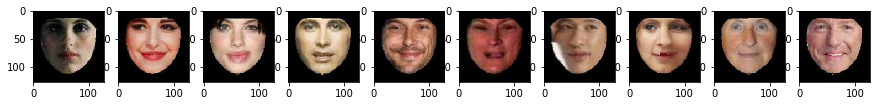

In [16]:
plt.figure(figsize = (15,1.5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(appearance_test[i,:,:,:])

plt.figure(figsize = (15,1.5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(warp_appearance_test[i,:,:,:])

In [17]:
#get HSV, V cahnnel dataset for appearance
warp_appearance_hsv_train = []
warp_appearance_hsv_test = []
for i in range(n_train):
    image_hsv = color.rgb2hsv(warp_appearance_train[i])
    warp_appearance_hsv_train.append(image_hsv)

for i in range(n_test):
    image_hsv = color.rgb2hsv(warp_appearance_test[i])
    warp_appearance_hsv_test.append(image_hsv)
    
warp_appearance_hsv_train = np.array(warp_appearance_hsv_train)
warp_appearance_hsv_test = np.array(warp_appearance_hsv_test)
warp_appearance_v_train = warp_appearance_hsv_train[:,:,:,2]
warp_appearance_v_test = warp_appearance_hsv_test[:,:,:,2]

/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/Users/ziqizhu/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


In [18]:
pca_warp_appearance = pca(warp_appearance_v_train)

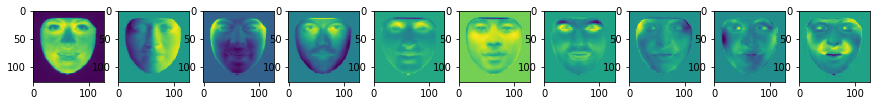

In [19]:
warp_eigen_faces = pca_warp_appearance.eigen_vectors[:, :10].T.reshape([-1, 128, 128])

plt.figure(figsize = (15,1.5))
for i in range(10):
    pc = warp_eigen_faces[i,:,:]
    plt.subplot(1,10,i+1)
    plt.imshow(pc)

[0.01037942335688823, 0.00553016562654465, 0.004547009480766961, 0.0039052094284554033, 0.003520691060535645, 0.003256214947971768, 0.0030319915356269572, 0.002852148052881837, 0.002696944250093954, 0.0025572225805291504]


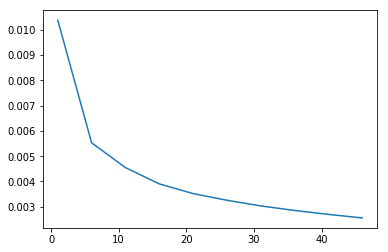

In [20]:
K_list = np.arange(1, h_appearance, 5)
reconstruction_errors = []
for K in K_list:
    reconstruction, error = pca_warp_appearance.reconstruct(warp_appearance_v_test.reshape([-1,128*128]), K)
    reconstruction_errors.append(error)

plt.plot(K_list, reconstruction_errors)

print(reconstruction_errors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

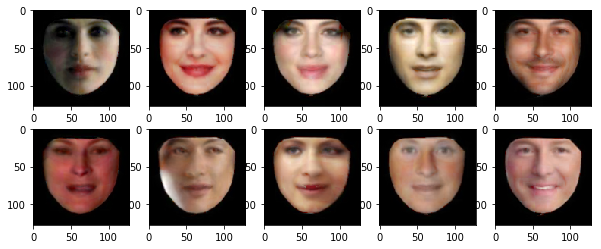

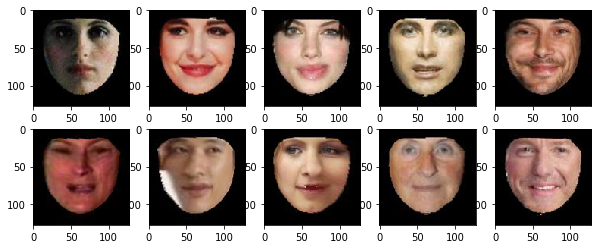

In [21]:
warp_appearance_reconstruction, _ = pca_warp_appearance.reconstruct(warp_appearance_v_test.reshape([-1,128*128]))

plt.figure(figsize = (10,4))
for i in range(10): #reconstruct 10 test images
    image_hsv = warp_appearance_hsv_test[i]
    image_hsv[:,:,2] = warp_appearance_reconstruction[i,:].reshape([-1,128,128])
    image_rgb = color.hsv2rgb(image_hsv)
    plt.subplot(2,5,i+1)
    plt.imshow(image_rgb)
    
plt.figure(figsize = (10,4))
for i in range(10): # 10 original test images
    image_rgb = warp_appearance_test[i]
    plt.subplot(2,5,i+1)
    plt.imshow(image_rgb)

## Synthesize random faces

In [22]:
nsample = 10
random_landmark = pca_landmark.sampling(n_sample = nsample).reshape(-1,68,2)
random_appearance = pca_warp_appearance.sampling(n_sample = nsample).reshape(-1,128,128)
print(random_landmark.shape)

(10, 68, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

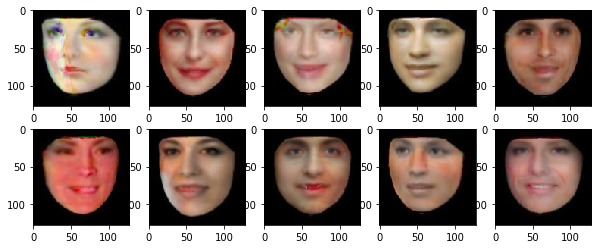

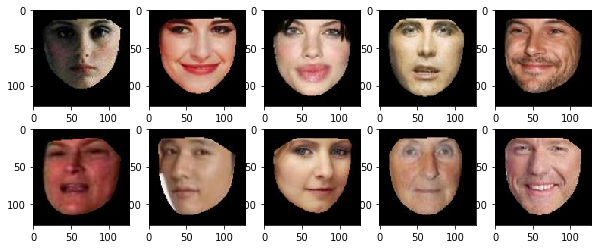

In [23]:
plt.figure(figsize = (10,4))
for i in range(10):
    warp_image_hsv = warp_appearance_hsv_test[i,:,:,:]
    warp_image_hsv[:,:,2] = random_appearance[i,:,:]
    warp_image_rgb = color.hsv2rgb(warp_image_hsv)
    image_rgb = mywarper.warp(warp_image_rgb, pca_landmark.mean.reshape(68,2),random_landmark[i,:,:])
    plt.subplot(2,5,i+1)
    plt.imshow(image_rgb)
    
    
plt.figure(figsize = (10,4))
for i in range(10): # 10 original test images
    image_rgb = appearance_test[i]
    plt.subplot(2,5,i+1)
    plt.imshow(image_rgb)